# ДЗ 3. A/B-тестирование, ранговые критерии, бутстрэп

Дедлайн: 19.12.2023 в 23:59

Вот и наступило время решать заключительное ДЗ в рамках курса ПСМО! Что вам нужно будет сделать (вкратце):

- Всё дз в рамках одного набора данных о рекламной платформе
- Сначала необходимо выбрать правильное сплитование данных из 3 предложенных, на основании значения которой будет происходить A/B тест. Обосновать выбор, проверив необходимые предпосылки однородности А и В выборок с помощью ранговых критериев и изученного статистического аппарата (2 балла)
- * Может приключиться такая ситуация, что выбранное сплитование не совсем подходит для проведения A/B, поэтому не поленитесь выбрать ту, для которой интерпретация каждого из ранговых критериев соответствует вашим исходным предположениям
- Провести A/B тест и подвести итоги со всеми статистиками, использовать техники с семинара для повышения чувствительности/корректности А/В теста (3.5 балла)
- Реализовать бутстрап как альтернативный метод проверки гипотеы, поставленной в А/В (3 балла)
- Содержательные выводы по итогам работы, интерпретирующие результат с бизнесовой точки зрения, как минимум 3-4 предложения (1.5 балла)

Бонусы!
- +1 балл к дз, если до проведения основной части работы вы реализуете ЕМ-алгоритм для разделения смеси распределений (подсказка: смесей от 2 до 4)
- +1 балл к дз, если реализуете CUPED в рамках анализа результатов А/В

P.s. Кажется, если вы хорошо поняли крайние 3 темы курса, на решение ДЗ и интерпретацию результатов у вас уйдёт не больше 3-4 часов. Это дз больше про понимание и умение интерпретировать полученное, а не про фундаментальную математику

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ZolotarevStat/psmo_22_23/2023/df_hw3.csv')
data

,id,split_1,split_2,split_3,is_teenager,num_segments,views,clicks,ctr
0,0,A,B,A,0,15,62,3,0.048387
1,1,A,B,B,0,4,5,0,0.000000
2,2,B,A,B,1,14,47,1,0.021277
3,3,B,A,B,1,2,3,0,0.000000
4,4,B,A,B,0,11,50,0,0.000000
...,...,...,...,...,...,...,...,...,...
19995,19995,B,A,A,1,4,5,0,0.000000
19996,19996,B,A,B,1,2,7,0,0.000000
19997,19997,A,B,A,0,6,22,5,0.227273
19998,19998,A,A,B,0,10,52,0,0.000000


Что есть в датасете для выполнения домашки:
* id - идентификатор пользователя
* split_1 - вариант сплитования 1
* split_2 - вариант сплитования 2
* split_3 - вариант сплитования 3
* is_teenager - меньше ли 25 лет пользователю
* num_segments - количество сегментов интересов [футбол, баскетбол, киберспорт, etc.] у пользователя
* views - просмотры рекламы в рамках проведённого эксперимента
* clicks - клики по рекламе в рамках проведённого эксперимента
* CTR - views / clicks

## Бонус: EM (1 балл)

Реализуйте ЕМ-алгоритм для разделения смеси распределений (подсказка: смесей от 2 до 4) исходных данных. Реализация поможет лучше интерпретировать полученные результаты по ходу всего ДЗ


Для начала посмотрим на графики распределений значений в разных колонках

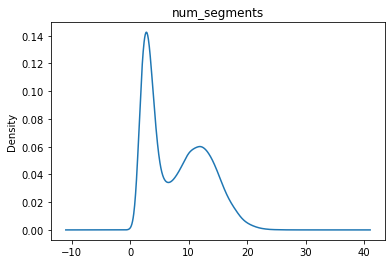

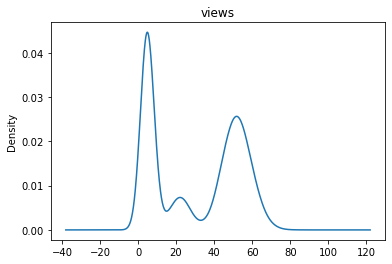

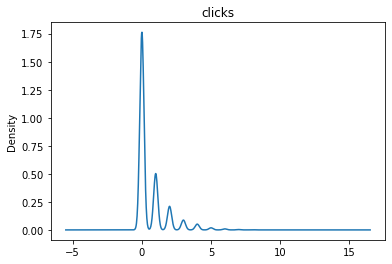

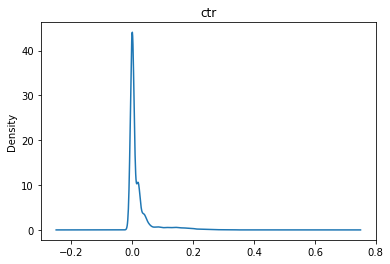

In [3]:
numeric_cols = ["num_segments", "views", "clicks", "ctr"]
for col in numeric_cols:
    plt.title(col)
    data[col].plot(kind='kde')
    plt.show()

Самые явные пики видны на первых двух графиках - на одном два, на другом три (На третьем странные пики обсуловлены лишь тем, что величина дискретная). Поэтому логично считать, что мы имеем дело с тремя смесями и будем делать EM-алгоритм именно по колонке views

In [4]:
from scipy.stats import norm 
from tqdm import tqdm

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def em_algorithm(df, column_name, max_iterations=100):
    # Инициализация параметров моделей
    num_samples = len(df)
    mu = [df[column_name].min(), df[column_name].mean(), df[column_name].max()]
    sigma = [1, 1, 1]
    weights = [1 / 3, 1 / 3, 1 / 3]

    # EM-алгоритм
    for _ in range(max_iterations):
        # E-шаг
        responsibilities = []
        for i in range(3):
            responsibility = weights[i] * norm.pdf(df[column_name], mu[i], sigma[i])
            responsibilities.append(responsibility)
        responsibilities = np.array(responsibilities)
        responsibilities /= np.sum(responsibilities, axis=0)

        # M-шаг
        for i in range(3):
            N = np.sum(responsibilities[i])
            weights[i] = N / num_samples
            mu[i] = np.sum(responsibilities[i] * df[column_name]) / N
            sigma[i] = np.sqrt(np.sum(responsibilities[i] * (df[column_name] - mu[i]) ** 2) / N)

    clusters = []
    for i in range(3):
        cluster = df.copy()
        cluster['responsibility'] = responsibilities[i]
        cluster = cluster.sort_values(by='responsibility', ascending=False)
        clusters.append(cluster)

    return clusters, weights

clusters, weights = em_algorithm(data, 'views')

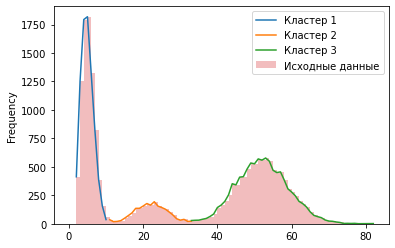

In [6]:
n = len(data['views'])
cutted_clusters = []

for i, cluster in enumerate(clusters):
    cutted_clusters.append(cluster.iloc[:int(n * weights[i])])
    
views_count = []
for i in range(3):
    views_count.append(pd.DataFrame(cutted_clusters[i].groupby('views').size()))
    plt.plot(views_count[-1], label=f'Кластер {i + 1}')
ind = range(data['views'].max() + 1)
data['views'].plot(bins=ind, kind='hist', alpha=0.3, label='Исходные данные')
plt.legend()
plt.show()

Очень интересно проверить и другие колонки, например num_segments:

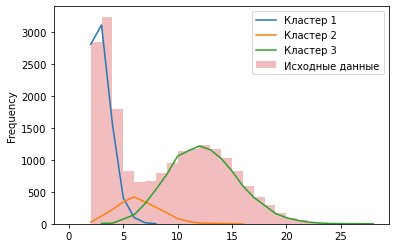

In [7]:
ns_count = []
for i in range(3):
    ns_count.append(pd.DataFrame(cutted_clusters[i].groupby('num_segments').size()))
    plt.plot(ns_count[-1], label=f'Кластер {i + 1}')
ind = range(data['num_segments'].max() + 1)
data['num_segments'].plot(bins=ind, kind='hist', alpha=0.3, label='Исходные данные')
plt.legend()
plt.show()

Ура! Несмотря на то, что мы разделяли смеси EM-алгоритмом по колонке views, пики на колонке num_segments также согласованы. Интересно также, что третий пик изначально был просто не заметен.

## Проверяем однородность разбиений (2 балла)

В этой части задания необходимо выбрать правильный метод разбиения выборки из предложенных вариантов [split_1, split_2, split_3], проверяя следующие гипотезы [при проверке используйте как минимум 2 ранговых критерия]:
* гипотеза о сдвиге
* гипотеза о масштабе
* гипотеза о независимости

Однородность разбиений необходимо проверять, используя только те данные, которые есть у нас ДО проведения А/В теста.

Разбалловка:
* За реализацию кода +0.5 балла
* За корректный и *обоснованный* выбор признаков, на основе которых проверяется однородность, +0.5 балла (при неверном выборе признаков 0 баллов за последующие части этого блока)
* За интерпретацию полученных результатов проверки гипотез +0.5 балла
* За выбор правильного метода разбиения по итогам блока +0.5 балла

NOTE: Обратите внимание на формат данных, имеющихся о пользователе до проведения эксперимента И внимательно подумайте над тем, каким образом можно проверить гипотезу о независимости

До проведения эксперимента у нас есть всего три колонки: num_segments, is_teenager и id. Колонка id могла бы быть информативной, если бы, например, какой-то из сплитов случайно использовал ее, но я никаких зависимостей не обнаружил, поэтому далее используем только num_segments и is_teenager.

Сначала интересно посмотреть на распределение num_segments в разных сплитах:

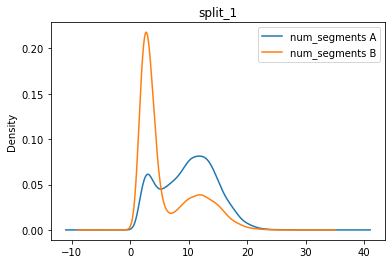

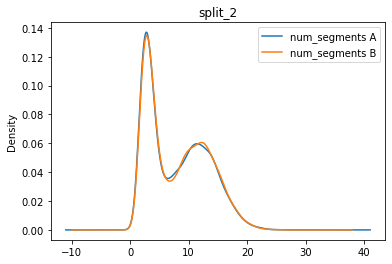

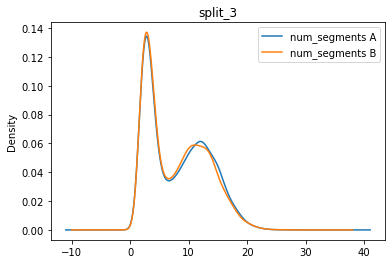

In [8]:
splits = ['split_1', 'split_2', 'split_3']

for split in splits:
    plt.title(f"{split}")
    for x in ['A', 'B']:
        data.loc[data[split] == x]["num_segments"].plot(kind='kde', label=f'num_segments {x}')
    plt.legend()
    plt.show()

Сразу видно, что в первом сплите происходит что-то супер странное. Чтобы все было честно, я все равно посчитаю для него статистические критерии, а пока сфокусируемся на 2 и 3 сплитах. Сначала посмотрим на гистограммы: 

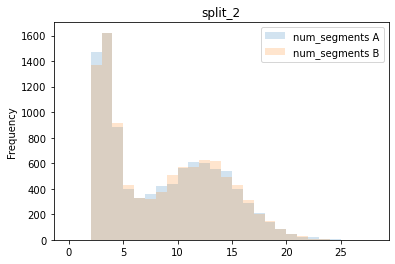

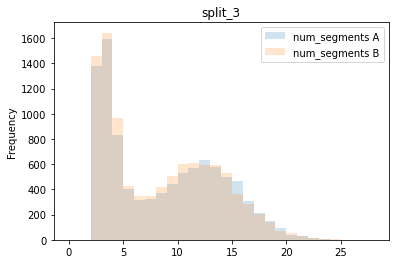

In [9]:
for split in splits[1:]:
    plt.title(f"{split}")
    for x in ['A', 'B']:
        data.loc[data[split] == x]["num_segments"].plot(kind='hist', alpha=0.2, bins=ind, label=f'num_segments {x}')
    plt.legend()
    plt.show()

Видно, что у 3-го сплита в группе B количество элементов num_segments, меньше либо равных 12 строго больше, чем в группе A для каждого такого значения, а 2-ой сплит более сбалансированный, поэтому пока больше всего веры именно в него. Еще посмотрим на количество элементов в разных группах и подгруппах в зависимости от начения is_teenager.

In [10]:
n = data.shape[0]
print("Total rows:", n)
for split in splits:
    print("####################")
    for x in ['A', 'B']:
        print(f"{split} - Rows in {x} group:", 
              len(data.loc[data[split] == x]))
        for y in [0, 1]:
            print(f"{split} - Rows in {x} group with is_teenager == {y}:", 
                  len(data.loc[data[split] == x].loc[data['is_teenager'] == y]))

Total rows: 20000
####################
split_1 - Rows in A group: 9978
split_1 - Rows in A group with is_teenager == 0: 9978
split_1 - Rows in A group with is_teenager == 1: 0
split_1 - Rows in B group: 10022
split_1 - Rows in B group with is_teenager == 0: 428
split_1 - Rows in B group with is_teenager == 1: 9594
####################
split_2 - Rows in A group: 10000
split_2 - Rows in A group with is_teenager == 0: 5222
split_2 - Rows in A group with is_teenager == 1: 4778
split_2 - Rows in B group: 10000
split_2 - Rows in B group with is_teenager == 0: 5184
split_2 - Rows in B group with is_teenager == 1: 4816
####################
split_3 - Rows in A group: 9789
split_3 - Rows in A group with is_teenager == 0: 5124
split_3 - Rows in A group with is_teenager == 1: 4665
split_3 - Rows in B group: 10211
split_3 - Rows in B group with is_teenager == 0: 5282
split_3 - Rows in B group with is_teenager == 1: 4929


В очередной раз убеждаемся, что в первом сплите что-то совершенно ужасное - в группе A, например, вообще нет строчек, для которых is_teenager == 1. А еще веры в 3-й сплит опять чуть меньше, так как 2-ой, в отличие от него, разделяет данные ровно пополам. А теперь посчитаем критерии, приняв уровень значимости $\alpha = 0.1$

Гипотезы о сдвиге и масштабе будем проверять на колонке num_segments, так как is_teenager принимает всего два значения: 0 и 1 (эта колонка понадобится нам позже, в проверке гипотез о независимости)

In [11]:
from scipy.stats import mannwhitneyu, ansari, kendalltau, spearmanr

In [12]:
for split in splits:
    print('###', split, 'begin', '###', sep='\t')
    print(mannwhitneyu(data.loc[data[split]=='A']['num_segments'],
                       data.loc[data[split]=='B']['num_segments']))
    print(ansari(data.loc[data[split]=='A']['num_segments'],
                       data.loc[data[split]=='B']['num_segments']))
    
    print('###', split, 'end', '###', sep='\t')

###	split_1	begin	###
MannwhitneyuResult(statistic=72674854.5, pvalue=0.0)
AnsariResult(statistic=54365047.5, pvalue=2.8525396665998405e-110)
###	split_1	end	###
###	split_2	begin	###
MannwhitneyuResult(statistic=49391497.5, pvalue=0.13428879372694635)
AnsariResult(statistic=49909292.5, pvalue=0.6328584524229113)
###	split_2	end	###
###	split_3	begin	###
MannwhitneyuResult(statistic=51018351.0, pvalue=0.010427959697644667)
AnsariResult(statistic=48304620.0, pvalue=0.0012752445758212724)
###	split_3	end	###


Для 1-го и 3-их сплитов и критерий Манна-Уитни, и критерий Ансари выдают p-value, меньший $\alpha$, следовательно, мы можем отклонить для них нулевую гипотезу о том, что данные в группах A и B распределены одинаково в пользу соответствующих альтернатив - гипотез о сдвиге и о масштабе. Для 2-го сплита мы не можем отклонить нулевую гипотезу на данном уровне значимости ни на одном из двух критериев.

Теперь проверим гипотезы независимости. Для начала, просто интересно проверить, зависят ли колонки num_segments и is_teenager в исходных данных: 

In [13]:
print(kendalltau(data['is_teenager'],
                 data['num_segments']))

KendalltauResult(correlation=-0.3480440053399894, pvalue=0.0)


p-value равен нулю, точно отклоняем нулевую гипотезу о независимости. Зависимость этих величин хорошо видна на графике:

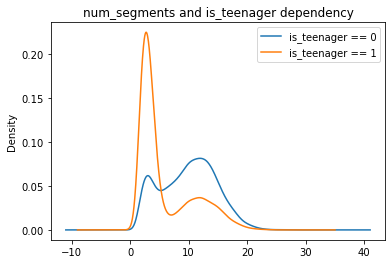

In [14]:
plt.title("num_segments and is_teenager dependency")
for y in [0, 1]:
    data.loc[data['is_teenager'] == y]["num_segments"].plot(kind='kde', label=f'is_teenager == {y}')
plt.legend()
plt.show()    

Посмотрим теперь, есть ли корреляция между разбиением на группы в сплитах и значением num_segments внутри кластеров с разным значением is_teenager

In [15]:
for split in splits:
    print('###', split, 'begin', '###', sep='\t')
    print("is_teenager == 0:",
          kendalltau(data.loc[data['is_teenager']==0][split],
                     data.loc[data['is_teenager']==0]['num_segments']))
    print("is_teenager == 1:",
          kendalltau(data.loc[data['is_teenager']==1][split],
                     data.loc[data['is_teenager']==1]['num_segments']))
    print('###', split, 'end', '###', sep='\t')

###	split_1	begin	###
is_teenager == 0: KendalltauResult(correlation=-0.006731946477376289, pvalue=0.4142933171977963)
is_teenager == 1: KendalltauResult(correlation=nan, pvalue=nan)
###	split_1	end	###
###	split_2	begin	###
is_teenager == 0: KendalltauResult(correlation=0.012600193563424684, pvalue=0.1265161990381717)
is_teenager == 1: KendalltauResult(correlation=0.013631750401475304, pvalue=0.1256534981463989)
###	split_2	end	###
###	split_3	begin	###
is_teenager == 0: KendalltauResult(correlation=-0.015177353744679089, pvalue=0.0656935084248891)
is_teenager == 1: KendalltauResult(correlation=-0.0092969823276769, pvalue=0.2962650476262463)
###	split_3	end	###


Как и ожидалось, первый сплит выдал NaN на втором тесте (так как в одной из групп нет is_teenager == 1). Что интересно, на обусловленном уровне значимости 0.1 мы не можем отвергнуть нулевую гипотезу о нулевой корреляции между разбиением и num_segments для 2-го сплита, а для 3-го отвергаем на случае is_teenager == 0. При этом, заметим, что для случая is_teenager == 1 3-й сплит показывает большой p-value и если бы это была рабочая задача, за которую мне бы платили деньги, я бы оставил 3-й сплит на группе is_teenager == 1, а для остальных переделал бы. Тогда есть надежда, что получилось бы 1) получить такой же большой p-value в первом случае, 2) добиться разбиения 50/50 как во втором сплите 3) использовать больший уровень значимости. Но сейчас в целях академического упрощения возьмем 2-й сплит, для которого мы приняли все интересующие нулевые гипотезы на уровне значимости 0.1

## Подводим результаты А/В (3.5 балла)

Теперь, когда мы выбрали подходящее сплитование для нашего набора данных, мы можем посмотреть на результирующие метрики, которые получились по результатам А/В теста. В рамках данной части необходимо сделать следующее:
1. Сформулировать нулевую и альтернативную гипотезу для теста (0.5)
2. Сравнить значения получившихся значений целевых метрик, формально проверить гипотезу и интерпретировать результат (0.5)
3. Реализовать хотя бы два из пройденных на семинаре методов для уточнения корректности полученных результатов, если они здесь применимы (2 балла)
3. * Бакетизация
3. * Пост-стратификация
3. * Дельта-метод
4. За красивую и хорошо интерпретируемую визуализацию 0.5 балла

Нулевая гипотеза - между двумя группами нет статистически значимой разницы в показателях CTR. Альтернатива - между двумя группами есть статистически значимая разницы в показателях CTR

Сначала посмотрим на средние показатели метрики и графики распределения в зависимости от группы, а также средние показатели связанных величин clicks и views (ctr = clicks/views):

In [16]:
split = 'split_2'

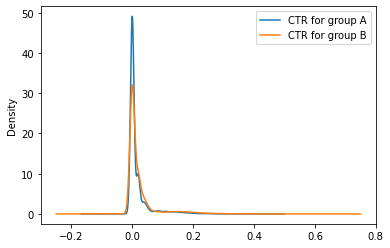

In [17]:
for x in ['A', 'B']:
    data.loc[data[split] == x]["ctr"].plot(kind='kde', label=f'CTR for group {x}')
plt.legend()
plt.show()

In [18]:
print(f"A ctr: {np.mean(data.loc[data[split] == 'A']['ctr'])}", 
      f"B ctr: {np.mean(data.loc[data[split] == 'B']['ctr'])}",
      f"A clicks: {np.mean(data.loc[data[split] == 'A']['clicks'])}", 
      f"B clicks: {np.mean(data.loc[data[split] == 'B']['clicks'])}",
      f"A views: {np.mean(data.loc[data[split] == 'A']['views'])}", 
      f"B views: {np.mean(data.loc[data[split] == 'B']['views'])}", sep='\n')

A ctr: 0.015159714308328305
B ctr: 0.02250157059359595
A clicks: 0.4781
B clicks: 0.7194
A views: 30.0
B views: 30.1807


Видно, что показатели действительно отличаются. Теперь проверим статистическую значимость:

In [19]:
from scipy.stats import ttest_ind

In [20]:
ttest_ind(data.loc[data[split] == 'A']['ctr'], data.loc[data[split] == 'B']['ctr'])

Ttest_indResult(statistic=-11.909575568214926, pvalue=1.3600249067188855e-32)

p-value показывает, что мы с хорошей уверенностью можем отклонить нулевую гипотезу. Копнем чуть глубже - проверим статистическую значимость в рамках следующих гипотез (исходя из того, что мы увидели в средних показателях метрик):

Нулевая гипотеза - между двумя группами нет статистически значимой разницы в показателях clicks. Альтернатива - между двумя группами есть статистически значимая разницы в показателях clicks

In [21]:
ttest_ind(data.loc[data[split] == 'A']['clicks'], data.loc[data[split] == 'B']['clicks'])

Ttest_indResult(statistic=-15.734587251493144, pvalue=1.885215055544248e-55)

Данную гипотезу мы также можем отклонить. На всякий случай, сформулируем и проверим аналогичные гипотезы для views:

In [22]:
ttest_ind(data.loc[data[split] == 'A']['views'], data.loc[data[split] == 'B']['views'])

Ttest_indResult(statistic=-0.5555216934690308, pvalue=0.5785440903206311)

При любом адекватном уровне значимости мы принимаем нулевую гипотезу для views, т.е. изменения, тетсируемые в рамках данного эксперимента никак не влияют на views, повышают значения clicks и, следовательно, повышают CTR. Но копнем еще глубже - сначала применим пост-стратификацию, используя колонку is_teenager

### Пост-стратификация

In [23]:
data_agg = data.groupby('is_teenager')[split].count().reset_index()
display(data_agg)
data_stratification = data.merge(data_agg.rename(columns={split:'weight'}), on='is_teenager')
data['weight'] = data_stratification['weight'] / len(data_stratification) * len(data_agg)
data

,is_teenager,split_2
0,0,10406
1,1,9594


,id,split_1,split_2,split_3,is_teenager,num_segments,views,clicks,ctr,weight
0,0,A,B,A,0,15,62,3,0.048387,1.0406
1,1,A,B,B,0,4,5,0,0.000000,1.0406
2,2,B,A,B,1,14,47,1,0.021277,1.0406
3,3,B,A,B,1,2,3,0,0.000000,1.0406
4,4,B,A,B,0,11,50,0,0.000000,1.0406
...,...,...,...,...,...,...,...,...,...,...
19995,19995,B,A,A,1,4,5,0,0.000000,0.9594
19996,19996,B,A,B,1,2,7,0,0.000000,0.9594
19997,19997,A,B,A,0,6,22,5,0.227273,0.9594
19998,19998,A,A,B,0,10,52,0,0.000000,0.9594


Мы добавили колонку с весом на основе значений is_teenager. Теперь можем повторить эксперименты:

In [24]:
target_cols = ['ctr', 'clicks', 'views']

In [25]:
for target in target_cols:
    print(f'post-strat t-test {target}:', ttest_ind(data.loc[data[split] == 'A'][target] * \
          data.loc[data[split] == 'A']['weight'],
          data.loc[data[split] == 'B'][target] * \
          data.loc[data[split] == 'B']['weight']))

post-strat t-test ctr: Ttest_indResult(statistic=-11.849492662291029, pvalue=2.7765560006205666e-32)
post-strat t-test clicks: Ttest_indResult(statistic=-15.658573964745733, pvalue=6.155922254925916e-55)
post-strat t-test views: Ttest_indResult(statistic=-0.4588963434815447, pvalue=0.6463135920590486)


На тесте для views мы получили заметно большее значение p-value, что радует. Это делает вывод про отсутствия эффекта от эксперимента на views (как положительного, так и отрицательного!) более уверенным. Мы пользовались t-тестом. Логично уточнить его корректность с помощью дельта-метода

### Дельта-метод

In [26]:
# использовал реализацию отсюда:
# https://habr.com/ru/companies/X5Tech/articles/740476/

def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)
        array_x = np.array(data.copy())
        array_y = np.array([1] * n_user)
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

for target in target_cols:
    print(f"Delta method p-value for {target}:",
          check_delta_method(data.loc[data[split] == 'A'][target],
                             data.loc[data[split] == 'B'][target]))

Delta method p-value for ctr: 0.0
Delta method p-value for clicks: 0.0
Delta method p-value for views: 0.5785188816046618


Видимо, в виду некоторых вычислительно-числовых особенностей мы получили ровно ноль на первых двух тестах. В целом, дельта-метод в очередной раз подтверждает предыдущие выводы

**Но не будем спешить с выводами!**

Я бы хотел глянуть еще глубже, а именно вернуться к результатам EM-алгоритма.

### Использование EM

Еще раз проведем тесты про CTR, но на трех разных кластерах, полученных в EM

In [55]:
for i in range(3):
    dat = cutted_clusters[i]
    print(ttest_ind(dat.loc[dat[split] == 'A']['ctr'], dat.loc[dat[split] == 'B']['ctr']))

Ttest_indResult(statistic=-2.1829225974665216, pvalue=0.02907047011146339)
Ttest_indResult(statistic=-15.33021919839631, pvalue=2.6493552112859313e-50)
Ttest_indResult(statistic=-15.903016914831563, pvalue=2.9752871486050955e-56)


И видим крайне интересный результат (На первом кластере p-value сильно выше, чем на других, и равен 0.02)! Он будет описан в выводах в конце :)

Пока упомяну лишь три важных пункта:
1) Я разбивал кластеры по колонке views, т.е. после эксперимента
2) Оказалось, что соотношение представителей групп A и B равно примерно 50/50 для всех кластеров (см. первый блок кода ниже)
3) Улучшение средних показателей лучше у первого кластера, при этом, они могут быть обусловлены случайностью, как показали тесты выше (см. второй блок кода ниже)

In [28]:
for i in range(3):
    print(len(cutted_clusters[i].loc[cutted_clusters[i][split] == 'A']) / len(cutted_clusters[i]))

0.501311680199875
0.5133950316609839
0.49617706237424547


In [29]:
for i in range(3):
    print(np.mean(cutted_clusters[i].loc[cutted_clusters[i][split] == 'B']['ctr']) /
          np.mean(cutted_clusters[i].loc[cutted_clusters[i][split] == 'A']['ctr']))

1.8787597564844547
1.5069558945070567
1.5444943003305032


## bootstrap (3 балла)

Ещё раз подведите итоги проведённого А/В теста, используя [бутстрэп](https://habr.com/ru/companies/X5Tech/articles/679842/)

1. Оцените разницу в метриках, используя наивный бутстрэп и прокомментируйте, изменился ли результат А/В теста (1 балл)
2. Оцените разницу в метриках, используя t-бутстрэп и прокомментируйте, изменился ли результат А/В теста (1 балл)
3. Оцените разницу в метриках, используя BCA бутстрэп и прокомментируйте, изменился ли результат А/В теста (1 балл)

Тут я потратил кучу времени на то, чтобы поиграться с разными параметрами и статистиками, но никаких информативных инсайдов вытянуть не получилось :( Поэтому, построим с помощью разных стратегий бутстрэпа доверительные интервалы для оценки среднего разницы в метриках (для ее оценки, как сказано в задании), а после этого сделаем вывод.  

Смотрим именно на среднее (разных таргетов из B минус то же для A), так как это более интересно с бизнесовой точки зрения, а не какую-нибудь другую простую статистику, например, медиану, которая характарезует какого-то конкретного юзера, а не всю аудиторию в целом.

In [38]:
def percentile_bootstrap(array1, array2):
    print(stats.bootstrap((array2 - array1, ), np.mean, confidence_level=0.9, method='percentile'))

for target in target_cols:
    print(f"percentile bootstrap for {target}")
    res = percentile_bootstrap(np.array(data.loc[data[split] == 'A'][target]), 
                               np.array(data.loc[data[split] == 'B'][target]))

percentile bootstrap for ctr
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.006297170803476937, high=0.008362185175021835), standard_error=0.0006267100074368952)
percentile bootstrap for clicks
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.216, high=0.2668), standard_error=0.015504353980311601)
percentile bootstrap for views
BootstrapResult(confidence_interval=ConfidenceInterval(low=-0.35932000000000003, high=0.7070600000000001), standard_error=0.32395852103595807)


In [39]:
from tqdm import tqdm

In [40]:
def t_bootstrap(array1, array2, num_samples=10000, num_subsamples=100):
    # Код взят с семинара
    
    bootstrap_ses = []

    X = array2 - array1
    ## Шаг 1: Найдите точечную оценку неизвестного параметра
    x_hat = np.mean(X)
    ## Шаг 2: Сгенерируйте 100 boostrap-выборок из X и сохраните их в матрицу n x 100
    bootstrap_samples = np.random.choice(X, size = (len(X), num_samples), replace = True)
    # Шаг 2: Рассчитайте выборочное среднее по каждой bootstrap-выборке
    bootstrap_means = np.mean(bootstrap_samples, axis = 0)

    # Шаг 3: Генерируем подвыборки, по которым считаем стандартное отклонение
    for i in tqdm(range(bootstrap_samples.shape[1])):
      bootstrap_subsamples = np.random.choice(bootstrap_samples[:, i], size = (len(X), num_subsamples), replace=True)
      bootstrap_subsamples_mean = np.mean(bootstrap_subsamples, axis = 0)
      bootstrap_ses.append(np.std(bootstrap_subsamples_mean))
    bootstrap_ses = np.array(bootstrap_ses)

    # Шаг 4: Рассчитайте T
    T = (bootstrap_means - x_hat) / bootstrap_ses
    # Шаг 5: Найдите 0.05 и 0.95 квантили для t_star
    T_quantiles = np.quantile(T, (0.05, 0.95))

    # Шаг 6: посчитайте стандартное отклонение для подстановки в формулу
    bootstrap_std = np.std(bootstrap_means)

    # Шаг 7: Постройте 90%-ый доверительный интервал для mu
    LB = x_hat - T_quantiles[1] * bootstrap_std
    UB = x_hat - T_quantiles[0] * bootstrap_std
    print('[', LB, ';', UB, ']')

for target in target_cols:
    print(f"t-bootstrap for {target}")
    t_bootstrap(np.array(data.loc[data[split] == 'A'][target]), 
                np.array(data.loc[data[split] == 'B'][target]))


t-bootstrap for ctr


100%|█████████████████████████████████████| 10000/10000 [02:12<00:00, 75.72it/s]


[ 0.006308840983119546 ; 0.008370146340506401 ]
t-bootstrap for clicks


100%|█████████████████████████████████████| 10000/10000 [02:19<00:00, 71.76it/s]


[ 0.21570137515196527 ; 0.26714574946134023 ]
t-bootstrap for views


100%|█████████████████████████████████████| 10000/10000 [02:22<00:00, 69.95it/s]

[ -0.35678060449996063 ; 0.7355860924773062 ]


In [59]:
def bca_bootstrap(array1, array2):
    cutted_array1, cutted_array2 = array1[:min(len(array1), len(array2))], array2[:min(len(array1), len(array2))]
    cutted = max(len(array1), len(array2)) - len(cutted_array1)
    if cutted:
        print(f"WARNING: cutted {cutted} elements")
    return stats.bootstrap((cutted_array2 - cutted_array1, ), np.mean, confidence_level=0.9, method='bca')

for target in target_cols:
    print(f"bca bootstrap for {target}")
    res = bca_bootstrap(np.array(data.loc[data[split] == 'A'][target]), 
                        np.array(data.loc[data[split] == 'B'][target]))
    print(res)

bca bootstrap for ctr
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.006321795719124251, high=0.00837807097717409), standard_error=0.00062370297713686)
bca bootstrap for clicks
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.216, high=0.267), standard_error=0.015492693232075696)
bca bootstrap for views
BootstrapResult(confidence_interval=ConfidenceInterval(low=-0.35262510098579314, high=0.7108436326391478), standard_error=0.3254261866153765)


Все три доверительных интервала очень похожи по значениям и согласуются со всеми предыдущими выводами - с 90% conf. level соответствующие интервалы для ctr и clicks содержат строго положительные значения (т.е. изменение, добавленное группе B приводит к улучшению), а вот про views нельзя уверенно ничего сказать. Как я сказал выше, это согласуется с прежними результатами, поэтому разумно еще раз прибегнуть к старому доброму EM

### Использование EM для интерпретации результатов бутстрэпа

Буду использовать BCa, так как он более устойчив по сравнению с percentile и гораздо более быстрый, чем t-bootstrap

In [62]:
views_hb = []
for i in range(3):
    print(f"bca bootstrap for cluster {i} with views target")
    res = bca_bootstrap(np.array(cutted_clusters[i].loc[cutted_clusters[i][split] == 'A']['views']), 
                        np.array(cutted_clusters[i].loc[cutted_clusters[i][split] == 'B']['views']))
    print(res)
    views_hb.append(res.confidence_interval.high)
    
clicks_lb = []
for i in range(3):
    print(f"bca bootstrap for cluster {i} with views target")
    res = bca_bootstrap(np.array(cutted_clusters[i].loc[cutted_clusters[i][split] == 'A']['clicks']), 
                        np.array(cutted_clusters[i].loc[cutted_clusters[i][split] == 'B']['clicks']))
    print(res)
    clicks_lb.append(res.confidence_interval.low)
    
print(tmph, tmpl)

bca bootstrap for cluster 0 with views target
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.06788577154308617, high=0.0841683366733467), standard_error=0.004968008220796374)
bca bootstrap for cluster 1 with views target
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.006006006006006006, high=0.3973973973973974), standard_error=0.11814170845128771)
bca bootstrap for cluster 2 with views target
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.04927007299270073, high=0.11151662611516626), standard_error=0.018926406726365246)
bca bootstrap for cluster 0 with views target
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.001503006012024048, high=0.008517034068136272), standard_error=0.0020850841406824592)
bca bootstrap for cluster 1 with views target
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.9069069069069069, high=1.1391391391391392), standard_error=0.07049522599422847)
bca bootstrap for cluster 2 with views target
Bootst

И вновь получен согласованный результат: на первом кластере в доверительные интервалы попали аплифты колонки views заметно большие по сравнению со значениями clicks, близкими к lower bound. А на втором и третьем - даже lower bound для clicks будет оказывать более сильный эффект по сравнению с upper bound для views (несложно показать это для нашей конечной метрики, дроби ctr = clicks / views, которая лежит в диапазоне от 0 до 1)

## Выводы (1.5 балла)

Содержательные выводы по итогам работы, интерпретирующие результат с бизнесовой точки зрения, как минимум 3-4 предложения

**NOTE:** если вы неверно выберете фичу сплитования или интерпретация полученных результатов А/В окажется некорректной, то за этот пункт будет поставлено 0 баллов вне зависимости от объёма выводов

Итак, сначала кратко повторю хронологию.

1) Имея все данные об эксперименте, в том числе полученные после его проведения, я разделил пользователей на три смеси по колонке просмотров с помощью EM. Это разделение не использовалось в проверке однородности сплитов, но помогла с пониманием данных по ходу всего анализа, в частности, в конце, при анализе аплифтов и их статистических обоснованностей. Было выделено три группы пользователей, у которых распределение views близко к нормальному внутри каждого из этих кластеров.
2) Проверка однородности (гипотезы сдвига, масштаба и независимости), в ходе которой был выбран split_2
3) Затем был проведен анализ результатов AB с помощью различных критериев, пост-стратификации, дельта-метода и бутстрэпов, который приводит к следующему результату:

ВЫВОД

Было выяснено, что пользователей можно разбить на три группы, в зависимости от соответствующего значения колонки views. Оказалось, что это оказывает непосредственное влияние на результаты AB. Для пользователей 2-го и 3-го кластеров нет сомнений в выигрыше от введения изменений, протестированных на группе B. Для пользователей же первого кластера такое изменение может понести некоторые, пускай незначительные риски. Поэтому с точки зрения бизнеса нужно
а) учесть расходы изменений, зависят ли они от количества пользователей и их характеристик?
б) улучшить сегментацию, провести CustDev с тремя группами людей, выявить их отличительные черты.

## Бонус: CUPED (1 балл)

Опишите понятным проверяющему языком, каким образом работает CUPED и реализуйте его для проведённого А/В теста

К сожалению, в рамках данного датасета это не реализовать, хотя я очень хотел :)

Дело в том, что CUPED принимает на вход информацию о метрике пользоватей обеих групп до эксперимента и после и делает некоторый adjustment (конкретные формулы не буду копипастить, читал вот здесь: https://bytepawn.com/reducing-variance-in-ab-testing-with-cuped.html), который уменьшает дисперсию оценки аплифта.

В этом же датасете нет информации о пользователях до проведения эксперимента